# Identifying country names from incomplete house addresses

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
<li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-2">Prerequisites</a></span></li>
<li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li>
<li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-4">Data preparation</a></span></li>
<li><span><a href="#TextClassifier-model" data-toc-modified-id="TextClassifier-model-5">TextClassifier model</a></span></li>
<ul class="toc-item">
<li><span><a href="#Load-model-architecture" data-toc-modified-id="Load-model-architecture-5.1">Load model architecture</a></span></li>
<li><span><a href="#Model-training" data-toc-modified-id="Model-training-5.2">Model training</a></span></li>    
<li><span><a href="#Validate-results" data-toc-modified-id="Validate-results-5.3">Validate results</a></span></li>
<li><span><a href="#Model-metrics" data-toc-modified-id="Model-metrics-5.4">Model metrics</a></span></li>    
<li><span><a href="#Get-misclassified-records" data-toc-modified-id="Get-misclassified-records-5.5">Get misclassified records</a></span></li>
<li><span><a href="#Saving-the-trained-model" data-toc-modified-id="Saving-the-trained-model-5.6">Saving the trained model</a></span></li>
</ul>
<li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-6">Model inference</a></span></li>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li>
<li><span><a href="#References" data-toc-modified-id="References-8">References</a></span></li>
</ul></div>

# Introduction

[Geocoding](https://en.wikipedia.org/wiki/Geocoding) is the process of taking input text, such as an **address** or the name of a place, and returning a **latitude/longitude** location for that place. In this notebook, we will be picking up a dataset consisting of incomplete house addresses from 10 countries. We will build a classifier using `TextClassifier` class of `arcgis.learn.text` module to predict the country for these incomplete house addresses. 

The house addresses in the dataset consist of text in multiple languages like English, Japanese, French, Spanish, etc. The dataset is a small subset of the house addresses taken from [OpenAddresses data](http://results.openaddresses.io/) 

**A note on the dataset**
- The data is collected around 2020-05-27 by [OpenAddresses](http://openaddresses.io).
- The data licenses can be found in `data/country-classifier/LICENSE.txt`.

# Prerequisites

- Data preparation and model training workflows using arcgis.learn have a dependency on [transformers](https://huggingface.co/transformers/v3.0.2/index.html). Refer to the section **"Install deep learning dependencies of arcgis.learn module"** [on this page](https://developers.arcgis.com/python/guide/install-and-set-up/#Install-deep-learning-dependencies) for detailed documentation on the installation of the dependencies.

- **Labeled data**: For `TextClassifier` to learn, it needs to see documents/texts that have been assigned a label. Labeled data for this sample notebook is located at `data/country-classifier/house-addresses.csv`

- To learn more about how `TextClassifier` works, please see the guide on [Text Classification with arcgis.learn](https://developers.arcgis.com/python/guide/text-classification).

# Imports

In [1]:
import os
import zipfile
import pandas as pd
from pathlib import Path
from arcgis.gis import GIS
from arcgis.learn import prepare_textdata
from arcgis.learn.text import TextClassifier

In [2]:
gis = GIS('home')

# Data preparation

Data preparation involves splitting the data into training and validation sets, creating the necessary data structures for loading data into the model and so on. The `prepare_data()` function can directly read the training samples and automate the entire process.

<Item title:"identifying_country_names_from_incomplete_house_addresses" type:Image Collection owner:api_data_owner>
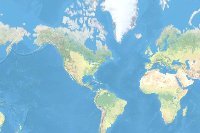

In [3]:
training_data = gis.content.get('a03dbdea5f7e46bea2f5b4355158211b')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
DATA_ROOT = Path(os.path.join(os.path.splitext(filepath)[0]))

In [7]:
data = prepare_textdata(DATA_ROOT, "classification", train_file="house-addresses.csv", 
                        text_columns="Address", label_columns="Country", batch_size=64)

The `show_batch()` method can be used to see the training samples, along with labels.

In [8]:
data.show_batch(10)

source,target
"300, CALLE GALEANA, CIUDAD SABINAS HIDALGO, Sabinas Hidalgo, Nuevo León",MX
"8, Rue Debussy, Villepinte, 93420",FR
"21D, Jorezstraat, D 5, 1070",BE
"3106, CASTLE ROCK LN",US
"SN, CALLE NINGUNO, SAN JOSÉ DEL CABO, Los Cabos, Baja California Sur",MX
"32, TR CRONISTA MUNTAN, 12006",ES
"SN, ESTRADA SANTO ANTONIO, CASA, Cunha Porã, SC, 89890-000",BR
"5770, Hillcrest Crescent, Niagara Falls",CA
"9, CL VILLAFRIA, 33008",ES
"1956-9, 藤岡町甲",JP


# TextClassifier model

`TextClassifier` model in `arcgis.learn.text` is built on top of [Hugging Face Transformers](https://huggingface.co/transformers/v3.0.2/index.html) library. The model training and inferencing workflow are similar to computer vision models in `arcgis.learn`. 

Run the command below to see what backbones are supported for the text classification task.

In [9]:
print(TextClassifier.supported_backbones)

['BERT', 'RoBERTa', 'DistilBERT', 'ALBERT', 'FlauBERT', 'CamemBERT', 'XLNet', 'XLM', 'XLM-RoBERTa', 'Bart', 'ELECTRA', 'Longformer', 'MobileBERT', 'Funnel']


Call the model's `available_backbone_models()` method with the backbone name to get the available models for that backbone. The call to **available_backbone_models** method will list out only few of the available models for each backbone. Visit [this](https://huggingface.co/transformers/pretrained_models.html) link to get a complete list of models for each backbone.

In [10]:
print(TextClassifier.available_backbone_models("xlm-roberta"))

('xlm-roberta-base', 'xlm-roberta-large')


## Load model architecture

Invoke the `TextClassifier` class by passing the data and the backbone you have chosen. The dataset consists of house addresses in multiple languages like Japanese, English, French, Spanish, etc., hence we will use a [multi-lingual transformer backbone](https://huggingface.co/transformers/v3.0.2/multilingual.html) to train our model.

In [11]:
model = TextClassifier(data, backbone="xlm-roberta-base")

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

## Model training

The `learning rate`[[1]](#References) is a **tuning parameter** that determines the step size at each iteration while moving toward a minimum of a loss function, it represents the speed at which a machine learning model **"learns"**. `arcgis.learn` includes a learning rate finder, and is accessible through the model's `lr_find()` method, that can automatically select an **optimum learning rate**, without requiring repeated experiments.

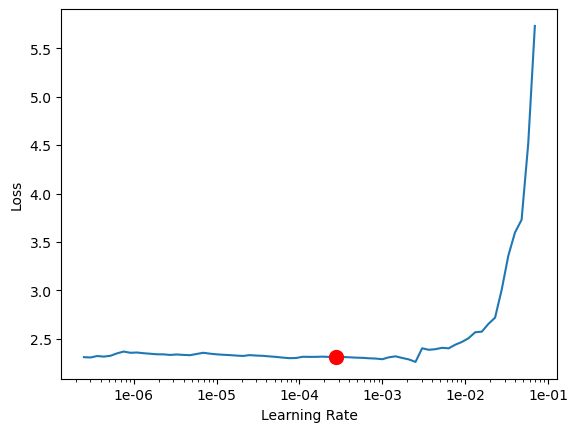

0.0002754228703338166

In [12]:
model.lr_find()

Training the model is an iterative process. We can train the model using its `fit()` method till the validation loss (or error rate) continues to go down with each training pass also known as an epoch. This is indicative of the model learning the task.

In [14]:
model.fit(epochs=6, lr=0.001)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.334708,2.331704,0.099820,0.900180,02:57
1,2.316825,2.304658,0.100020,0.899980,02:57
2,2.314339,2.302908,0.100020,0.899980,02:56
3,2.306808,2.303009,0.100020,0.899980,02:57
4,2.303068,2.302679,0.100020,0.899980,02:56
5,2.302748,2.302599,0.100020,0.899980,02:58


## Validate results

Once we have the trained model, we can see the results to see how it performs.

In [13]:
model.show_results(15)

text,target,prediction
"SN, CALLE INGENIERO PABLO HÉCTOR GONZÁLEZ GONZÁLEZ, PABELLÓN DE ARTEAGA, Pabellón de Arteaga, Aguascalientes",MX,BE
"SN, ESTRADA VICINAL GLEBA QUINZE, SITIO MOT DS OLV LOTE 1 QUADRA C, Euclides da Cunha Paulista, SP, 19275-000",BR,BE
"32, CIRCUITO JOSÉ MARÍA URIARTE, FRACCIONAMIENTO RANCHO ALEGRE, Tlajomulco de Zúñiga, Jalisco",MX,BE
"SN, CERRADA RÍO PÁNUCO, PUERTO ESCONDIDO (TEPEOLULCO PUERTO ESCONDIDO), Tlalnepantla de Baz, México",MX,BE
"807, AVENIDA LIC. ADOLFO LOPEZ MATEOS OTE., AGUASCALIENTES, Aguascalientes, Aguascalientes",MX,BE
"SN, PROLONGACIÓN PUEBLA, DOLORES HIDALGO CUNA DE LA INDEPENDENCIA NACIONAL, Dolores Hidalgo Cuna de la Independencia Nacional, Guanajuato",MX,BE
"148, CIRCUITO CIRCUITO INTERIOR (PROFESOR JOSÉ VASCONCELOS), CUAUHTÉMOC, Cuauhtémoc, Distrito Federal",MX,BE
"34, CALLE MELCHOR OCAMPO, COLONIA LÁZARO CÁRDENAS (1RA. SECCIÓN DEL RODEO), San Juan del Río, Querétaro",MX,BE
"SN, CALLE MANUEL ÁVILA CAMACHO, POZA RICA DE HIDALGO, Poza Rica de Hidalgo, Veracruz de Ignacio de la Llave",MX,BE
"423, CALLE NINGUNO, FRACCIONAMIENTO CIUDAD OLMECA, Coatzacoalcos, Veracruz de Ignacio de la Llave",MX,BE


### Test the model prediction on an input text

In [14]:
text = """1016, 8A, CL RICARDO LEON - SANTA ANA (CARTAGENA), 30319"""
print(model.predict(text))

('1016, 8A, CL RICARDO LEON - SANTA ANA (CARTAGENA), 30319', 'BE', 0.13564284145832062)


## Model metrics

To get a sense of how well the model is trained, we will calculate some important metrics for our `text-classifier` model. First, to find how accurate[[2]](#References) the model is in correctly predicting the classes in the dataset, we will call the model's `accuracy()` method.

In [15]:
model.accuracy()

0.1

Other important metrics to look at are Precision, Recall & F1-measures [[3]](#References). To find `precision`, `recall` & `f1` scores per label/class we will call the model's `metrics_per_label()` method.

In [16]:
model.metrics_per_label()

,Precision_score,Recall_score,F1_score,Support
AU,1.0,0.0,0.0000,1000.0
BE,0.1,1.0,0.1818,1000.0
BR,1.0,0.0,0.0000,1000.0
CA,1.0,0.0,0.0000,1000.0
ES,1.0,0.0,0.0000,1000.0
FR,1.0,0.0,0.0000,1000.0
JP,1.0,0.0,0.0000,1000.0
MX,1.0,0.0,0.0000,1000.0
US,1.0,0.0,0.0000,999.0
ZA,1.0,0.0,0.0000,1000.0


## Get misclassified records

Its always a good idea to see the cases where your model is not performing well. This step will help us to:
- Identify if there is a problem in the dataset.
- Identify if there is a problem with text/documents belonging to a specific label/class.  
- Identify if there is a class imbalance in your dataset, due to which the model didn't see much of the labeled data for a particular class, hence not able to learn properly about that class.

To get the **misclassified records** we will call the model's `get_misclassified_records` method.

In [17]:
misclassified_records = model.get_misclassified_records()

In [23]:
## Check pandas version 
import pandas
print(pandas.__version__)

2.0.2


In [19]:
##if pandas version is older than 1.3.0, Use df.style.hide_index() function.
misclassified_records.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])\
        .set_properties(**{'text-align': "left"}).hide()

## Saving the trained model

Once you are satisfied with the model, you can save it using the save() method. This creates an Esri Model Definition (EMD file) that can be used for inferencing on unseen data.

In [25]:
model.save("country-classifier")

Computing model metrics...


WindowsPath('models/country-classifier')

# Model inference

The trained model can be used to classify new text documents using the predict method. This method accepts a string or a list of strings to predict the labels of these new documents/text.

In [26]:
text_list = data._train_df.sample(15).Address.values
result = model.predict(text_list)

df = pd.DataFrame(result, columns=["Address", "CountryCode", "Confidence"])

df.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])\
        .set_properties(**{'text-align': "left"}).hide()

Address,CountryCode,Confidence
"179, RUA JOSE BARBALHO FILHO, APARTAMENTO 103 BLOCO G, João Pessoa, PB, 58027-000",BR,1.000000
"2531, PARTRIDGE CRES",CA,0.834484
"SN, CALLE ESCUINAPA, URUAPAN, Uruapan, Michoacán de Ocampo",MX,1.000000
"44, WOODFORD DR, FREDERICKSBURG, Stafford County, VA, 22405",US,0.999997
"587, CALLE CABO SAN LUCAS, ENSENADA, Ensenada, Baja California",MX,1.000000
"80009, Street, Fernie, Chief Albert Luthuli",ZA,0.999997
"1906, Pelton Mountain Rd, Chipman Brook, Kings County",CA,0.999895
"1, Chemin de Promelles, 1472",BE,0.999912
"1408, Cedarglen Court, Oakville, ON",CA,0.998583
"70, POPLAR ST N",CA,0.942083


# Conclusion

In this notebook, we have built a text classifier using `TextClassifier` class of `arcgis.learn.text` module. The dataset consisted of house addresses of 10 countries written in languages like English, Japanese, French, Spanish, etc. To achieve this we used a [multi-lingual transformer backbone](https://huggingface.co/transformers/v3.0.2/multilingual.html) like `XLM-RoBERTa` to build a classifier to predict the country for an input house address. 

# References

[1] [Learning Rate](https://en.wikipedia.org/wiki/Learning_rate)

[2] [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)

[3] [Precision, recall and F1-measures](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures)